In [160]:
import cv2
import sys
import math
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

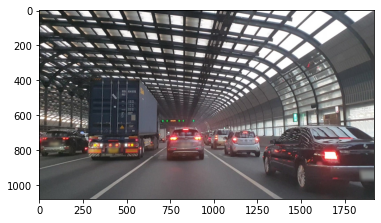

In [173]:
### 0. plt버전 이미지 불러오기
#img = "/Users/yu/tf39_test/실습/자율주행_신호등인식/train/데이터/차선_샘플/a.jpg"
img = "./1080p/1 (1).jpg"
A = mpimg.imread(img, cv2.IMREAD_COLOR)

plt.imshow(A)

In [174]:
"""
### 0. 이미지 불러오기
#img = "/Users/yu/tf39_test/실습/자율주행_신호등인식/train/데이터/차선_샘플/a.jpg"
img = "./1080p/1 (150).jpg"
A = cv2.imread(img, cv2.IMREAD_COLOR)

cv2.imshow("A",A)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
"""

'\n### 0. 이미지 불러오기\n#img = "/Users/yu/tf39_test/실습/자율주행_신호등인식/train/데이터/차선_샘플/a.jpg"\nimg = "./1080p/1 (150).jpg"\nA = cv2.imread(img, cv2.IMREAD_COLOR)\n\ncv2.imshow("A",A)\n\ncv2.waitKey(0)\ncv2.destroyAllWindows()\ncv2.waitKey(1)\n'

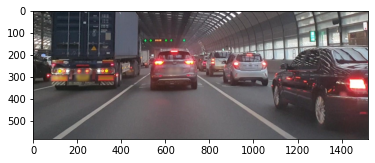

In [175]:
# plt 버전
# ROI 지정(중앙쪽으로) 1520*580
A_roi = A.copy()

X=200; Y=500; W=1520; H=580;
A_roi = A_roi[Y:Y+H, X:X+W]

plt.imshow(A_roi)

In [176]:
"""
# ROI 지정(중앙쪽으로) 1520*580
A_roi = A.copy()

X=200; Y=500; W=1520; H=580;
A_roi = A_roi[Y:Y+H, X:X+W]

cv2.imshow("A_roi",A_roi)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
"""

'\n# ROI 지정(중앙쪽으로) 1520*580\nA_roi = A.copy()\n\nX=200; Y=500; W=1520; H=580;\nA_roi = A_roi[Y:Y+H, X:X+W]\n\ncv2.imshow("A_roi",A_roi)\n\ncv2.waitKey(0)\ncv2.destroyAllWindows()\ncv2.waitKey(1)\n'

In [177]:
"""
# 고속도로용
# ROI 지정(중앙쪽으로) 1920*1080
A_roi = A.copy()

X=500; Y=400; W=1100; H=400;
A_roi = A_roi[Y:Y+H, X:X+W]
cv2.imshow("A_roi",A_roi)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
"""

'\n# 고속도로용\n# ROI 지정(중앙쪽으로) 1920*1080\nA_roi = A.copy()\n\nX=500; Y=400; W=1100; H=400;\nA_roi = A_roi[Y:Y+H, X:X+W]\ncv2.imshow("A_roi",A_roi)\n\ncv2.waitKey(0)\ncv2.destroyAllWindows()\ncv2.waitKey(1)\n'

In [178]:
A_roi.shape[:3]

(580, 1520, 3)

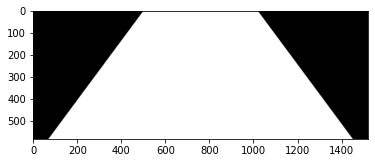

In [179]:
### 1. 차선 진행 방향 고려해서 roi 지정(사다리꼴)
# roi 사다리꼴 마스크 설정
mask1 = np.zeros(A_roi.shape[:3],dtype = np.uint8)

polygon = np.array([[500,0],[1020,0],[1450,580],[70,580]])
white = (255,255,255)

mask1 = cv2.fillPoly(mask1,[polygon],white)

plt.imshow(mask1)
# plt.imshow(A_roi)

In [180]:
"""
### 1. 차선 진행 방향 고려해서 roi 지정(사다리꼴)
# roi 사다리꼴 마스크 설정
mask1 = np.zeros(A_roi.shape[:3],dtype = np.uint8)

polygon = np.array([[500,0],[1020,0],[1450,580],[70,580]])
white = (255,255,255)

mask1 = cv2.fillPoly(mask1,[polygon],white)

cv2.imshow("mask1",mask1)
cv2.imshow("original",A_roi)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
"""

'\n### 1. 차선 진행 방향 고려해서 roi 지정(사다리꼴)\n# roi 사다리꼴 마스크 설정\nmask1 = np.zeros(A_roi.shape[:3],dtype = np.uint8)\n\npolygon = np.array([[500,0],[1020,0],[1450,580],[70,580]])\nwhite = (255,255,255)\n\nmask1 = cv2.fillPoly(mask1,[polygon],white)\n\ncv2.imshow("mask1",mask1)\ncv2.imshow("original",A_roi)\n\ncv2.waitKey(0)\ncv2.destroyAllWindows()\ncv2.waitKey(1)\n'

In [181]:
"""
### 1. 차선 진행 방향 고려해서 roi 지정(사다리꼴)
## 고속도로용
# roi 사다리꼴 마스크 설정
mask1 = np.zeros(A_roi.shape[:3],dtype = np.uint8)

polygon = np.array([[(400, 0), (50, 400), (1050, 400), (600, 0)]])
white = (255,255,255)

mask1 = cv2.fillPoly(mask1,[polygon],white)

cv2.imshow("mask1",mask1)
cv2.imshow("original",A_roi)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
"""

'\n### 1. 차선 진행 방향 고려해서 roi 지정(사다리꼴)\n## 고속도로용\n# roi 사다리꼴 마스크 설정\nmask1 = np.zeros(A_roi.shape[:3],dtype = np.uint8)\n\npolygon = np.array([[(400, 0), (50, 400), (1050, 400), (600, 0)]])\nwhite = (255,255,255)\n\nmask1 = cv2.fillPoly(mask1,[polygon],white)\n\ncv2.imshow("mask1",mask1)\ncv2.imshow("original",A_roi)\n\ncv2.waitKey(0)\ncv2.destroyAllWindows()\ncv2.waitKey(1)\n'

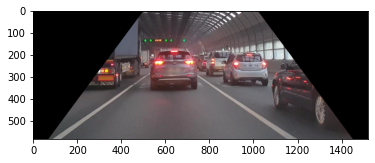

In [182]:
# roi 사다리꼴 자르기
a_copy = A_roi.copy()
a_result = cv2.bitwise_and(a_copy, mask1)

plt.imshow(a_result) # 본래의 색인 마스크

In [183]:
### 2. hsv에서 흰색 차선 후보 검출, hsv에서 노랑색 차선 후보 검출

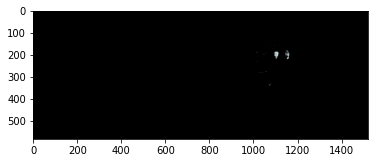

In [184]:
## plt버전 노란색 부분 추출
a = a_result.copy()
# hsv 영역 전환
a2 = cv2.cvtColor(a,cv2.COLOR_BGR2HSV)

# hsv 색 범위 지정2
low = (20, 20, 100)
up = (31, 255, 255)

a2_mask = cv2.inRange(a2, low, up)
a2_result = cv2.bitwise_and(a,a, mask = a2_mask)

plt.imshow(a) # 원본
plt.imshow(a2_mask) # 마스크
plt.imshow(a2_result) # 본래의 색인 마스크

In [185]:
"""
## 노란색 부분 추출
a = a_result.copy()
# hsv 영역 전환
a2 = cv2.cvtColor(a,cv2.COLOR_BGR2HSV)

# hsv 색 범위 지정2
low = (20, 20, 100)
up = (31, 255, 255)

a2_mask = cv2.inRange(a2, low, up)
a2_result = cv2.bitwise_and(a,a, mask = a2_mask)

cv2.imshow('color',a) # 원본
cv2.imshow('mask',a2_mask) # 마스크
cv2.imshow('result',a2_result) # 본래의 색인 마스크

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
"""

"\n## 노란색 부분 추출\na = a_result.copy()\n# hsv 영역 전환\na2 = cv2.cvtColor(a,cv2.COLOR_BGR2HSV)\n\n# hsv 색 범위 지정2\nlow = (20, 20, 100)\nup = (31, 255, 255)\n\na2_mask = cv2.inRange(a2, low, up)\na2_result = cv2.bitwise_and(a,a, mask = a2_mask)\n\ncv2.imshow('color',a) # 원본\ncv2.imshow('mask',a2_mask) # 마스크\ncv2.imshow('result',a2_result) # 본래의 색인 마스크\n\ncv2.waitKey(0)\ncv2.destroyAllWindows()\ncv2.waitKey(1)\n"

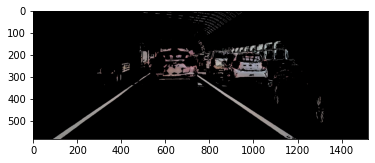

In [186]:
## plt버전 흰색 부분 추출
a = a_result.copy()
# hsv 영역 전환
a2 = cv2.cvtColor(a,cv2.COLOR_BGR2HSV)

# bgr 색 범위 지정
#low = (0, 255, 255)
#up = (200, 255, 255)

# hsv 색 범위 지정2
low = (0, 0, 140)
up = (250, 90, 200)

a2_mask = cv2.inRange(a2, low, up)
a2_result = cv2.bitwise_and(a,a, mask = a2_mask)

plt.imshow(a) # 원본
plt.imshow(a2_mask) # 마스크
plt.imshow(a2_result) # 본래의 색인 마스크

In [187]:
"""
## 흰색 부분 추출
a = a_result.copy()
# hsv 영역 전환
a2 = cv2.cvtColor(a,cv2.COLOR_BGR2HSV)

# bgr 색 범위 지정
#low = (0, 255, 255)
#up = (200, 255, 255)

# hsv 색 범위 지정2
low = (0, 0, 140)
up = (250, 90, 200)

a2_mask = cv2.inRange(a2, low, up)
a2_result = cv2.bitwise_and(a,a, mask = a2_mask)

cv2.imshow('color',a) # 원본
cv2.imshow('mask',a2_mask) # 마스크
cv2.imshow('result',a2_result) # 본래의 색인 마스크

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
"""

"\n## 흰색 부분 추출\na = a_result.copy()\n# hsv 영역 전환\na2 = cv2.cvtColor(a,cv2.COLOR_BGR2HSV)\n\n# bgr 색 범위 지정\n#low = (0, 255, 255)\n#up = (200, 255, 255)\n\n# hsv 색 범위 지정2\nlow = (0, 0, 140)\nup = (250, 90, 200)\n\na2_mask = cv2.inRange(a2, low, up)\na2_result = cv2.bitwise_and(a,a, mask = a2_mask)\n\ncv2.imshow('color',a) # 원본\ncv2.imshow('mask',a2_mask) # 마스크\ncv2.imshow('result',a2_result) # 본래의 색인 마스크\n\ncv2.waitKey(0)\ncv2.destroyAllWindows()\ncv2.waitKey(1)\n"

In [188]:
"""
## 고속도로용 흰색 부분 추출
a = a_result.copy()
# hsv 영역 전환
a2 = cv2.cvtColor(a,cv2.COLOR_BGR2HSV)

# bgr 색 범위 지정
#low = (0, 255, 255)
#up = (200, 255, 255)

# hsv 색 범위 지정2
low = (0, 0, 197)
up = (180, 80, 255)

a2_mask = cv2.inRange(a2, low, up)
a2_result = cv2.bitwise_and(a,a, mask = a2_mask)

cv2.imshow('color',a) # 원본
cv2.imshow('mask',a2_mask) # 마스크
cv2.imshow('result',a2_result) # 본래의 색인 마스크

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
"""

"\n## 고속도로용 흰색 부분 추출\na = a_result.copy()\n# hsv 영역 전환\na2 = cv2.cvtColor(a,cv2.COLOR_BGR2HSV)\n\n# bgr 색 범위 지정\n#low = (0, 255, 255)\n#up = (200, 255, 255)\n\n# hsv 색 범위 지정2\nlow = (0, 0, 197)\nup = (180, 80, 255)\n\na2_mask = cv2.inRange(a2, low, up)\na2_result = cv2.bitwise_and(a,a, mask = a2_mask)\n\ncv2.imshow('color',a) # 원본\ncv2.imshow('mask',a2_mask) # 마스크\ncv2.imshow('result',a2_result) # 본래의 색인 마스크\n\ncv2.waitKey(0)\ncv2.destroyAllWindows()\ncv2.waitKey(1)\n"

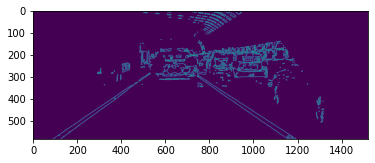

In [189]:
### 3. plt버전 캐니 활용해서 윤곽선 드러내기
# 캐니 추출

a2_canny = cv2.Canny(a2_result, 50 , 250)

plt.imshow(a2_canny)

In [190]:
"""
### 3. 캐니 활용해서 윤곽선 드러내기
# 캐니 추출

a2_canny = cv2.Canny(a2_result, 50 , 250)

cv2.imshow("a2_canny",a2_canny)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)
"""

'\n### 3. 캐니 활용해서 윤곽선 드러내기\n# 캐니 추출\n\na2_canny = cv2.Canny(a2_result, 50 , 250)\n\ncv2.imshow("a2_canny",a2_canny)\n\ncv2.waitKey(0)\ncv2.destroyAllWindows()\ncv2.waitKey(1)\n'

In [191]:
'''# 일반적 허프 선 변환
src = a2_result
dst = a2_canny
cdst = cv.cvtColor(a2_canny, cv.COLOR_GRAY2BGR)

cdstP = np.copy(cdst)

lines = cv2.HoughLines(dst, 1, np.pi/180, 50, srn = 100, stn = 200, min_theta = 0, max_theta = np.pi)'''

'# 일반적 허프 선 변환\nsrc = a2_result\ndst = a2_canny\ncdst = cv.cvtColor(a2_canny, cv.COLOR_GRAY2BGR)\n\ncdstP = np.copy(cdst)\n\nlines = cv2.HoughLines(dst, 1, np.pi/180, 50, srn = 100, stn = 200, min_theta = 0, max_theta = np.pi)'

In [192]:
'''# 확률적 허프 선 변환
src = a2_result
dst = a2_canny
cdst = cv.cvtColor(a2_canny, cv.COLOR_GRAY2BGR)

cdstP = np.copy(cdst)

linesP = cv.HoughLinesP(dst, 1, np.pi/180, 50, None, 50, 10)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 2, cv.LINE_AA)
        
        
cv.imshow("확률적 허프 선 변환", cdstP)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)'''

'# 확률적 허프 선 변환\nsrc = a2_result\ndst = a2_canny\ncdst = cv.cvtColor(a2_canny, cv.COLOR_GRAY2BGR)\n\ncdstP = np.copy(cdst)\n\nlinesP = cv.HoughLinesP(dst, 1, np.pi/180, 50, None, 50, 10)\n\nif linesP is not None:\n    for i in range(0, len(linesP)):\n        l = linesP[i][0]\n        cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 2, cv.LINE_AA)\n        \n        \ncv.imshow("확률적 허프 선 변환", cdstP)\n\ncv2.waitKey()\ncv2.destroyAllWindows()\ncv2.waitKey(1)'

In [193]:
# img :
# rho :
# theta :
# threshold : (점 임계값)
# lines : 검출된 넘파이 배열 선 좌표들 (생략) None
# minlinelength : (선 최소 길이)
# maxLineGap : (선사이 최대 허용간격)

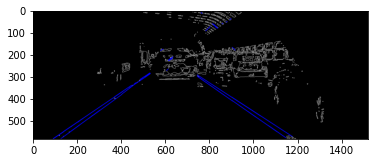

In [194]:
### 4. plt버전 하프변환P로 차선 긋기
# 검출된 데이터 없으면 오류 뜨므로 수정 요함
r = []
l = []
src = a2_result
dst = a2_canny
cdst = cv.cvtColor(a2_canny, cv.COLOR_GRAY2BGR)

cdstP = np.copy(cdst)

linesP = cv2.HoughLinesP(dst, 1, np.pi/180, 60, None, 5, 5)
#if linesP != None: 리스트에 데이터 없으면 오류나서 추가해야함 근데 데이터 있으면 오류남
for a in linesP:
    for b in a: # [] 가 두개 겹쳐있음
        if (b[2]-b[0]) != 0: # 분모가 0이면 나눌 수 없어
            radian = math.atan((b[3]-b[1])/(b[2]-b[0]))
            degree = radian * 180 / math.pi
            if degree >= 30 and degree <= 80: # 오른쪽
                r.append(b)
                cv2.line(cdstP, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2, cv2.LINE_AA)
            elif degree >= -80 and degree <= -30: # 왼쪽
                l.append(b)
                cv2.line(cdstP, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2, cv2.LINE_AA)

plt.imshow(cdstP)

In [195]:
"""
### 4. 하프변환P로 차선 긋기
# 검출된 데이터 없으면 오류 뜨므로 수정 요함
r = []
l = []
src = a2_result
dst = a2_canny
cdst = cv.cvtColor(a2_canny, cv.COLOR_GRAY2BGR)

cdstP = np.copy(cdst)

linesP = cv2.HoughLinesP(dst, 1, np.pi/180, 60, None, 5, 5)
#if linesP != None: 리스트에 데이터 없으면 오류나서 추가해야함 근데 데이터 있으면 오류남
for a in linesP:
    for b in a: # [] 가 두개 겹쳐있음
        if (b[2]-b[0]) != 0: # 분모가 0이면 나눌 수 없어
            radian = math.atan((b[3]-b[1])/(b[2]-b[0]))
            degree = radian * 180 / math.pi
            if degree >= 30 and degree <= 80: # 오른쪽
                r.append(b)
                cv2.line(cdstP, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2, cv2.LINE_AA)
            elif degree >= -80 and degree <= -30: # 왼쪽
                l.append(b)
                cv2.line(cdstP, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2, cv2.LINE_AA)

cv.imshow("houghP", cdstP)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)
"""

'\n### 4. 하프변환P로 차선 긋기\n# 검출된 데이터 없으면 오류 뜨므로 수정 요함\nr = []\nl = []\nsrc = a2_result\ndst = a2_canny\ncdst = cv.cvtColor(a2_canny, cv.COLOR_GRAY2BGR)\n\ncdstP = np.copy(cdst)\n\nlinesP = cv2.HoughLinesP(dst, 1, np.pi/180, 60, None, 5, 5)\n#if linesP != None: 리스트에 데이터 없으면 오류나서 추가해야함 근데 데이터 있으면 오류남\nfor a in linesP:\n    for b in a: # [] 가 두개 겹쳐있음\n        if (b[2]-b[0]) != 0: # 분모가 0이면 나눌 수 없어\n            radian = math.atan((b[3]-b[1])/(b[2]-b[0]))\n            degree = radian * 180 / math.pi\n            if degree >= 30 and degree <= 80: # 오른쪽\n                r.append(b)\n                cv2.line(cdstP, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2, cv2.LINE_AA)\n            elif degree >= -80 and degree <= -30: # 왼쪽\n                l.append(b)\n                cv2.line(cdstP, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2, cv2.LINE_AA)\n\ncv.imshow("houghP", cdstP)\n\ncv2.waitKey()\ncv2.destroyAllWindows()\ncv2.waitKey(1)\n'

In [196]:
### 여기까지 하면 차선 양옆들 검출 성공

In [197]:
# 확인
r

[array([ 902,  390, 1176,  568], dtype=int32),
 array([745, 295, 866, 380], dtype=int32),
 array([ 975,  455, 1106,  546], dtype=int32),
 array([ 745,  289, 1032,  475], dtype=int32),
 array([747, 297, 906, 408], dtype=int32),
 array([824,  68, 829,  73], dtype=int32),
 array([ 903,  405, 1012,  481], dtype=int32),
 array([762,   6, 767,  11], dtype=int32),
 array([813,  56, 834,  77], dtype=int32),
 array([819,  59, 838,  78], dtype=int32),
 array([904, 164, 917, 177], dtype=int32),
 array([1068,  519, 1147,  574], dtype=int32)]

In [198]:
# 확인2
l

[array([505, 302, 531, 284], dtype=int32),
 array([274, 471, 402, 378], dtype=int32),
 array([139, 545, 408, 363], dtype=int32),
 array([168, 547, 303, 449], dtype=int32),
 array([486, 309, 507, 295], dtype=int32),
 array([614, 225, 631, 214], dtype=int32),
 array([615, 221, 635, 207], dtype=int32),
 array([464, 330, 499, 305], dtype=int32),
 array([459, 330, 468, 324], dtype=int32),
 array([126, 578, 210, 517], dtype=int32),
 array([ 91, 578, 227, 486], dtype=int32),
 array([616, 225, 632, 214], dtype=int32),
 array([509, 298, 532, 282], dtype=int32),
 array([876,  50, 881,  47], dtype=int32),
 array([404, 375, 463, 330], dtype=int32),
 array([892,  39, 899,  34], dtype=int32),
 array([618, 220, 631, 211], dtype=int32),
 array([857,  58, 862,  55], dtype=int32),
 array([203, 503, 209, 499], dtype=int32),
 array([437, 349, 462, 330], dtype=int32),
 array([370, 388, 447, 336], dtype=int32),
 array([ 91, 579, 138, 547], dtype=int32),
 array([253, 486, 295, 455], dtype=int32),
 array([511

In [199]:
# r과 l에서 길이를 조건으로 두어 추출하도록 재조정하여 리스트에 저장

In [200]:
new_r = []
new_l = []

In [201]:
for i in range(len(r)):
    if math.dist([r[i][0], r[i][1]], [r[i][2], r[i][3]]) > 100:
        new_r.append(r[i])
        
for i in range(len(l)):
    if math.dist([l[i][0], l[i][1]], [l[i][2], l[i][3]]) > 100:
        new_l.append(l[i])

In [202]:
new_r

[array([ 902,  390, 1176,  568], dtype=int32),
 array([745, 295, 866, 380], dtype=int32),
 array([ 975,  455, 1106,  546], dtype=int32),
 array([ 745,  289, 1032,  475], dtype=int32),
 array([747, 297, 906, 408], dtype=int32),
 array([ 903,  405, 1012,  481], dtype=int32)]

In [203]:
new_l

[array([274, 471, 402, 378], dtype=int32),
 array([139, 545, 408, 363], dtype=int32),
 array([168, 547, 303, 449], dtype=int32),
 array([126, 578, 210, 517], dtype=int32),
 array([ 91, 578, 227, 486], dtype=int32)]

In [204]:
"""
### 5. roi 이미지에서 선그리기 (+각 선들 특징에 맞게 위치 저장)
a_copy = A_roi.copy()

# r 에서 x0 최소값이 있는 인덱스 i 찾기
least = []
for x in r:
    least.append(x[0])
    
least_a = min(least)
i = least.index(least_a)

# r 에서 x0 최대값이 있는 인덱스 i2 찾기
most_a = max(least)
i2 = least.index(most_a)

# l 에서 x1 최소값이 있는 인덱스 i3 찾기
least2 = []
for x in l:
    least2.append(x[2])
    
least_b = min(least2)
i3 = least2.index(least_b)

# l 에서 x1 최대값이 있는 인덱스 i4 찾기  
most_b = max(least2)
i4 = least2.index(most_b)


cv2.line(a_copy, (r[i][0], r[i][1]), (r[i][2], r[i][3]), (0, 0, 255), 2, cv2.LINE_AA)
cv2.line(a_copy, (r[i2][0], r[i2][1]), (r[i2][2], r[i2][3]), (0, 0, 255), 2, cv2.LINE_AA)

cv2.line(a_copy, (l[i3][0], l[i3][1]), (l[i3][2], l[i3][3]), (0, 0, 255), 2, cv2.LINE_AA)
cv2.line(a_copy, (l[i4][0], l[i4][1]), (l[i4][2], l[i4][3]), (0, 0, 255), 2, cv2.LINE_AA)


cv.imshow("a_copy", a_copy)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)
"""

'\n### 5. roi 이미지에서 선그리기 (+각 선들 특징에 맞게 위치 저장)\na_copy = A_roi.copy()\n\n# r 에서 x0 최소값이 있는 인덱스 i 찾기\nleast = []\nfor x in r:\n    least.append(x[0])\n    \nleast_a = min(least)\ni = least.index(least_a)\n\n# r 에서 x0 최대값이 있는 인덱스 i2 찾기\nmost_a = max(least)\ni2 = least.index(most_a)\n\n# l 에서 x1 최소값이 있는 인덱스 i3 찾기\nleast2 = []\nfor x in l:\n    least2.append(x[2])\n    \nleast_b = min(least2)\ni3 = least2.index(least_b)\n\n# l 에서 x1 최대값이 있는 인덱스 i4 찾기  \nmost_b = max(least2)\ni4 = least2.index(most_b)\n\n\ncv2.line(a_copy, (r[i][0], r[i][1]), (r[i][2], r[i][3]), (0, 0, 255), 2, cv2.LINE_AA)\ncv2.line(a_copy, (r[i2][0], r[i2][1]), (r[i2][2], r[i2][3]), (0, 0, 255), 2, cv2.LINE_AA)\n\ncv2.line(a_copy, (l[i3][0], l[i3][1]), (l[i3][2], l[i3][3]), (0, 0, 255), 2, cv2.LINE_AA)\ncv2.line(a_copy, (l[i4][0], l[i4][1]), (l[i4][2], l[i4][3]), (0, 0, 255), 2, cv2.LINE_AA)\n\n\ncv.imshow("a_copy", a_copy)\n\ncv2.waitKey()\ncv2.destroyAllWindows()\ncv2.waitKey(1)\n'

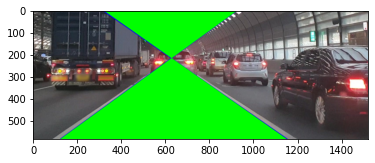

In [205]:
### 5. plt버전 roi 이미지에서 선그리기 (+각 선들 특징에 맞게 위치 저장)  
##- 좌측, 혹은 우측 리스트가 비어있는 경우 반대쪽 좌표를 옮겨오도록 함, 각도조정 필요 03.09

a_copy = A_roi.copy()

# r 에서 x0 최소값이 있는 인덱스 i 찾기
least = []
for x in new_r:
    least.append(x[0])

least2 = []
for x in new_l:
    least2.append(x[2])
        
if not least:
    least_a = least_b
    least.append(least_a)
    i = least2.index(least_a)
    most_a = most_b
    least.append(most_a)
    i2 = least2.index(max_a)
    least_b = min(least2)
    i3 = least2.index(least_b)
    most_b = max(least2)
    i4 = least2.index(most_b)
    a_copy2 = a_copy.copy()
    
    ## l1
    m3 = (l[i3][3]-l[i3][1])/(l[i3][2]-l[i3][0])
    n3 = l[i3][1] - (m3 * l[i3][0])

    ## l2
    m4 = (l[i4][3]-l[i4][1])/(l[i4][2]-l[i4][0])
    n4 = l[i4][1] - (m4 * l[i4][0])

    ## r
    m = -m3
    n = l[i][1] - (m * (550-(l[i][0]-550)))

    ## r2
    m2 = -m4
    n2 = l[i2][1] - (m2 * (550-(l[i2][0]-500)))
    

    cv2.line(a_copy2, (int(-n/m), 0),(int((1080-n)/m), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n2/m2), 0),(int((1080-n2)/m2), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n3/m3), 0),(int((1080-n3)/m3), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n4/m4), 0),(int((1080-n4)/m4), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    pts = np.array([[int(-n4/m4), 0],[int((1080-n4)/m4), 1080],[int((1080-n2)/m2), 1080], [int(-n2/m2), 0]], np.int32)
    cv2.fillPoly(a_copy2, pts, (0, 255, 0))

    
elif not least2:
    least_a = min(least)
    i = least.index(least_a)
    most_a = max(least)
    i2 = least.index(most_a)
    least_b = least_a
    i3 = least.index(least_b)
    most_b = most_a
    i4 = least.index(most_b)    
    a_copy2 = a_copy.copy()
    
    ## r
    m = (r[i][3]-r[i][1])/(r[i][2]-r[i][0])
    n = r[i][1] - (m * r[i][0])

    ## r2
    m2 = (r[i2][3]-r[i2][1])/(r[i2][2]-r[i2][0])
    n2 = r[i2][1] - (m2 * r[i2][0])

    ## l1
    m3 = -m
    n3 = r[i][1] - (m3 * (550-(r[i][0]-550)))

    ## l2
    m4 = -m2
    n4 = r[i2][1] - (m4 * (550-(r[i2][0]-550)))
    
    ## r1과 l2의 교차점
    c1 = (n4-n)/(m+m2)
    
    ## r2와 l1의 교차점
    c2 = (n3-n2)/(m2+m)


    cv2.line(a_copy2, (int(-n/m), 0),(int((1080-n)/m), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n2/m2), 0),(int((1080-n2)/m2), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n3/m3), 0),(int((1080-n3)/m3), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n4/m4), 0),(int((1080-n4)/m4), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (550, 0), (550, 1080), (255, 0, 0), 2, cv2.LINE_AA)
    pts = np.array([[int(-n4/m4), 0],[int((1080-n4)/m4), 1080],[int((1080-n2)/m2), 1080], [int(-n2/m2), 0]], np.int32)
    cv2.fillPoly(a_copy2, pts, (0, 255, 0))
    
else:
    least_a = min(least)
    i = least.index(least_a)
    most_a = max(least)
    i2 = least.index(most_a)
    least_b = min(least2)
    i3 = least2.index(least_b)
    most_b = max(least2)
    i4 = least2.index(most_b)
    a_copy2 = a_copy.copy()
    
    ## r
    m = (r[i][3]-r[i][1])/(r[i][2]-r[i][0])
    n = r[i][1] - (m * r[i][0])

    ## r2
    m2 = (r[i2][3]-r[i2][1])/(r[i2][2]-r[i2][0])
    n2 = r[i2][1] - (m2 * r[i2][0])

    ## l1
    m3 = (l[i3][3]-l[i3][1])/(l[i3][2]-l[i3][0])
    n3 = l[i3][1] - (m3 * l[i3][0])

    ## l2
    m4 = (l[i4][3]-l[i4][1])/(l[i4][2]-l[i4][0])
    n4 = l[i4][1] - (m4 * l[i4][0])


    cv2.line(a_copy2, (int(-n/m), 0),(int((1080-n)/m), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n2/m2), 0),(int((1080-n2)/m2), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n3/m3), 0),(int((1080-n3)/m3), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n4/m4), 0),(int((1080-n4)/m4), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    pts = np.array([[int(-n4/m4), 0],[int((1080-n4)/m4), 1080],[int((1080-n)/m), 1080], [int(-n/m), 0]], np.int32)
    area = cv2.fillPoly(a_copy2, [pts], (0, 255, 0))
    a_copy3 = cv2.addWeighted(a_copy2, 0.1, area, 0.9, 0)
    
plt.imshow(a_copy3)

In [206]:
"""
### 5. roi 이미지에서 선그리기 (+각 선들 특징에 맞게 위치 저장)  
##- 좌측, 혹은 우측 리스트가 비어있는 경우 반대쪽 좌표를 옮겨오도록 함, 각도조정 필요 03.09

a_copy = A_roi.copy()

# r 에서 x0 최소값이 있는 인덱스 i 찾기
least = []
for x in new_r:
    least.append(x[0])

least2 = []
for x in new_l:
    least2.append(x[2])
        
if not least:
    least_a = least_b
    least.append(least_a)
    i = least2.index(least_a)
    most_a = most_b
    least.append(most_a)
    i2 = least2.index(max_a)
    least_b = min(least2)
    i3 = least2.index(least_b)
    most_b = max(least2)
    i4 = least2.index(most_b)
    a_copy2 = a_copy.copy()
    
    ## l1
    m3 = (l[i3][3]-l[i3][1])/(l[i3][2]-l[i3][0])
    n3 = l[i3][1] - (m3 * l[i3][0])

    ## l2
    m4 = (l[i4][3]-l[i4][1])/(l[i4][2]-l[i4][0])
    n4 = l[i4][1] - (m4 * l[i4][0])

    ## r
    m = -m3
    n = l[i][1] - (m * (550-(l[i][0]-550)))

    ## r2
    m2 = -m4
    n2 = l[i2][1] - (m2 * (550-(l[i2][0]-500)))
    

    cv2.line(a_copy2, (int(-n/m), 0),(int((1080-n)/m), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n2/m2), 0),(int((1080-n2)/m2), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n3/m3), 0),(int((1080-n3)/m3), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n4/m4), 0),(int((1080-n4)/m4), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    pts = np.array([[int(-n4/m4), 0],[int((1080-n4)/m4), 1080],[int((1080-n2)/m2), 1080], [int(-n2/m2), 0]], np.int32)
    cv2.fillPoly(a_copy2, pts, (0, 255, 0))

    
elif not least2:
    least_a = min(least)
    i = least.index(least_a)
    most_a = max(least)
    i2 = least.index(most_a)
    least_b = least_a
    i3 = least.index(least_b)
    most_b = most_a
    i4 = least.index(most_b)    
    a_copy2 = a_copy.copy()
    
    ## r
    m = (r[i][3]-r[i][1])/(r[i][2]-r[i][0])
    n = r[i][1] - (m * r[i][0])

    ## r2
    m2 = (r[i2][3]-r[i2][1])/(r[i2][2]-r[i2][0])
    n2 = r[i2][1] - (m2 * r[i2][0])

    ## l1
    m3 = -m
    n3 = r[i][1] - (m3 * (550-(r[i][0]-550)))

    ## l2
    m4 = -m2
    n4 = r[i2][1] - (m4 * (550-(r[i2][0]-550)))
    
    ## r1과 l2의 교차점
    c1 = (n4-n)/(m+m2)
    
    ## r2와 l1의 교차점
    c2 = (n3-n2)/(m2+m)


    cv2.line(a_copy2, (int(-n/m), 0),(int((1080-n)/m), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n2/m2), 0),(int((1080-n2)/m2), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n3/m3), 0),(int((1080-n3)/m3), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n4/m4), 0),(int((1080-n4)/m4), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (550, 0), (550, 1080), (255, 0, 0), 2, cv2.LINE_AA)
    pts = np.array([[int(-n4/m4), 0],[int((1080-n4)/m4), 1080],[int((1080-n2)/m2), 1080], [int(-n2/m2), 0]], np.int32)
    cv2.fillPoly(a_copy2, pts, (0, 255, 0))
    
else:
    least_a = min(least)
    i = least.index(least_a)
    most_a = max(least)
    i2 = least.index(most_a)
    least_b = min(least2)
    i3 = least2.index(least_b)
    most_b = max(least2)
    i4 = least2.index(most_b)
    a_copy2 = a_copy.copy()
    
    ## r
    m = (r[i][3]-r[i][1])/(r[i][2]-r[i][0])
    n = r[i][1] - (m * r[i][0])

    ## r2
    m2 = (r[i2][3]-r[i2][1])/(r[i2][2]-r[i2][0])
    n2 = r[i2][1] - (m2 * r[i2][0])

    ## l1
    m3 = (l[i3][3]-l[i3][1])/(l[i3][2]-l[i3][0])
    n3 = l[i3][1] - (m3 * l[i3][0])

    ## l2
    m4 = (l[i4][3]-l[i4][1])/(l[i4][2]-l[i4][0])
    n4 = l[i4][1] - (m4 * l[i4][0])


    cv2.line(a_copy2, (int(-n/m), 0),(int((1080-n)/m), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n2/m2), 0),(int((1080-n2)/m2), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n3/m3), 0),(int((1080-n3)/m3), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    cv2.line(a_copy2, (int(-n4/m4), 0),(int((1080-n4)/m4), 1080), (0, 0, 255), 2, cv2.LINE_AA)
    pts = np.array([[int(-n4/m4), 0],[int((1080-n4)/m4), 1080],[int((1080-n)/m), 1080], [int(-n/m), 0]], np.int32)
    area = cv2.fillPoly(a_copy2, [pts], (0, 255, 0))
    a_copy3 = cv2.addWeighted(a_copy2, 0.1, area, 0.9, 0)
    
cv.imshow("a_copy", a_copy3)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)
"""

'\n### 5. roi 이미지에서 선그리기 (+각 선들 특징에 맞게 위치 저장)  \n##- 좌측, 혹은 우측 리스트가 비어있는 경우 반대쪽 좌표를 옮겨오도록 함, 각도조정 필요 03.09\n\na_copy = A_roi.copy()\n\n# r 에서 x0 최소값이 있는 인덱스 i 찾기\nleast = []\nfor x in new_r:\n    least.append(x[0])\n\nleast2 = []\nfor x in new_l:\n    least2.append(x[2])\n        \nif not least:\n    least_a = least_b\n    least.append(least_a)\n    i = least2.index(least_a)\n    most_a = most_b\n    least.append(most_a)\n    i2 = least2.index(max_a)\n    least_b = min(least2)\n    i3 = least2.index(least_b)\n    most_b = max(least2)\n    i4 = least2.index(most_b)\n    a_copy2 = a_copy.copy()\n    \n    ## l1\n    m3 = (l[i3][3]-l[i3][1])/(l[i3][2]-l[i3][0])\n    n3 = l[i3][1] - (m3 * l[i3][0])\n\n    ## l2\n    m4 = (l[i4][3]-l[i4][1])/(l[i4][2]-l[i4][0])\n    n4 = l[i4][1] - (m4 * l[i4][0])\n\n    ## r\n    m = -m3\n    n = l[i][1] - (m * (550-(l[i][0]-550)))\n\n    ## r2\n    m2 = -m4\n    n2 = l[i2][1] - (m2 * (550-(l[i2][0]-500)))\n    \n\n    cv2.line(a_copy2, (int(-n/m), 0),(int

In [207]:
"""
### 6. l, r 선길게 4개 긋기
a_copy2 = A_roi.copy()

# 기울기 m
# y절편 n

## r
m = (r[i][3]-r[i][1])/(r[i][2]-r[i][0])
n = r[i][1] - (m * r[i][0])

## r2
m2 = (r[i2][3]-r[i2][1])/(r[i2][2]-r[i2][0])
n2 = r[i2][1] - (m2 * r[i2][0])

## l1
m3 = (l[i3][3]-l[i3][1])/(l[i3][2]-l[i3][0])
n3 = l[i3][1] - (m3 * l[i3][0])

## l2
m4 = (l[i4][3]-l[i4][1])/(l[i4][2]-l[i4][0])
n4 = l[i4][1] - (m4 * l[i4][0])


cv2.line(a_copy2, (int(-n/m), 0),(int((580-n)/m), 580), (0, 0, 255), 2, cv2.LINE_AA)
cv2.line(a_copy2, (int(-n2/m2), 0),(int((580-n2)/m2), 580), (0, 0, 255), 2, cv2.LINE_AA)
cv2.line(a_copy2, (int(-n3/m3), 0),(int((580-n3)/m3), 580), (0, 0, 255), 2, cv2.LINE_AA)
cv2.line(a_copy2, (int(-n4/m4), 0),(int((580-n4)/m4), 580), (0, 0, 255), 2, cv2.LINE_AA)

cv2.imshow("a_copy2", a_copy2)

cv2.waitKey()
cv2.destroyAllWindows()
cv2.waitKey(1)
"""

'\n### 6. l, r 선길게 4개 긋기\na_copy2 = A_roi.copy()\n\n# 기울기 m\n# y절편 n\n\n## r\nm = (r[i][3]-r[i][1])/(r[i][2]-r[i][0])\nn = r[i][1] - (m * r[i][0])\n\n## r2\nm2 = (r[i2][3]-r[i2][1])/(r[i2][2]-r[i2][0])\nn2 = r[i2][1] - (m2 * r[i2][0])\n\n## l1\nm3 = (l[i3][3]-l[i3][1])/(l[i3][2]-l[i3][0])\nn3 = l[i3][1] - (m3 * l[i3][0])\n\n## l2\nm4 = (l[i4][3]-l[i4][1])/(l[i4][2]-l[i4][0])\nn4 = l[i4][1] - (m4 * l[i4][0])\n\n\ncv2.line(a_copy2, (int(-n/m), 0),(int((580-n)/m), 580), (0, 0, 255), 2, cv2.LINE_AA)\ncv2.line(a_copy2, (int(-n2/m2), 0),(int((580-n2)/m2), 580), (0, 0, 255), 2, cv2.LINE_AA)\ncv2.line(a_copy2, (int(-n3/m3), 0),(int((580-n3)/m3), 580), (0, 0, 255), 2, cv2.LINE_AA)\ncv2.line(a_copy2, (int(-n4/m4), 0),(int((580-n4)/m4), 580), (0, 0, 255), 2, cv2.LINE_AA)\n\ncv2.imshow("a_copy2", a_copy2)\n\ncv2.waitKey()\ncv2.destroyAllWindows()\ncv2.waitKey(1)\n'

In [208]:
####### 테스트한 코드 영역 ##########

In [187]:
'''print((r[i][0], r[i][1]), (r[i][2], r[i][3]))
print(m)
print(n)
print("==========")
print(-n/m)
print((580-n)/m)
print("==========")
print((int(-n/m), 0),(int((580-n)/m), 580))'''

'print((r[i][0], r[i][1]), (r[i][2], r[i][3]))\nprint(m)\nprint(n)\nprint("==========")\nprint(-n/m)\nprint((580-n)/m)\nprint("==========")\nprint((int(-n/m), 0),(int((580-n)/m), 580))'

In [188]:
'''print((r[i3][0], r[i3][1]), (r[i3][2], r[i3][3]))
print(m3)
print(n3)
print("==========")
print(-n3/m3)
print((580-n3)/m3)
print("==========")
print((int(-n3/m3), 0),(int((580-n3)/m3), 580))'''

'print((r[i3][0], r[i3][1]), (r[i3][2], r[i3][3]))\nprint(m3)\nprint(n3)\nprint("==========")\nprint(-n3/m3)\nprint((580-n3)/m3)\nprint("==========")\nprint((int(-n3/m3), 0),(int((580-n3)/m3), 580))'

In [159]:
# 다중 리스트에서 내림차순으로 정렬(다른 방법)

'''l2 = l
l2.sort(key=lambda x:x[2])
print(l2)'''

'l2 = l\nl2.sort(key=lambda x:x[2])\nprint(l2)'

In [160]:
'''radian = math.atan(3)

degree = radian * 180/ math.pi

print(degree)'''

'radian = math.atan(3)\n\ndegree = radian * 180/ math.pi\n\nprint(degree)'

In [161]:
'''for a in linesP:
    for b in a: # [] 가 두개 겹쳐있음
        radian = math.atan((b[3]-b[1])/(b[2]-b[0]))
        degree = radian * 180 / math.pi
        print(degree)'''

'for a in linesP:\n    for b in a: # [] 가 두개 겹쳐있음\n        radian = math.atan((b[3]-b[1])/(b[2]-b[0]))\n        degree = radian * 180 / math.pi\n        print(degree)'